# **PROJECT: TEXT GENERATION USING LSTM**

## 0. Setup

In [98]:
!pip install --upgrade tensorflow
!pip install --upgrade streamlit


In [99]:
import tensorflow as tf
import streamlit as st

print()
print("TensorFlow version:", tf.__version__)
print("Streamlit version:", st.__version__)




TensorFlow version: 2.15.0
Streamlit version: 1.33.0


## 1. Import All Dependencies

In [100]:
# module for building LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import tensorflow.keras.utils as ku

# set the seed (initial starting point for PRNG(pseudorandom number generator) to maintaing the consistency during generating the random numbers)
from numpy.random import seed
tf.random.set_seed(2)
seed(1)

# computaional module
import pandas as pd
import numpy as np
import string
import os

import json

# to ignore the warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [101]:
# specifying the directory path
BASE_DIR = '/kaggle/input/nyt-comments/'
WORKING_DIR = '/kaggle/working/'


## 2. Load the dataset
#### we are using the NewYork Times Comments and Headlines

In [102]:
os.listdir(BASE_DIR)

['CommentsFeb2018.csv',
 'ArticlesFeb2017.csv',
 'CommentsApril2018.csv',
 'ArticlesJan2017.csv',
 'ArticlesMay2017.csv',
 'CommentsJan2017.csv',
 'CommentsMarch2017.csv',
 'CommentsMay2017.csv',
 'CommentsMarch2018.csv',
 'CommentsApril2017.csv',
 'ArticlesMarch2017.csv',
 'ArticlesApril2017.csv',
 'CommentsFeb2017.csv',
 'ArticlesJan2018.csv',
 'ArticlesFeb2018.csv',
 'ArticlesMarch2018.csv',
 'CommentsJan2018.csv',
 'ArticlesApril2018.csv']

In [103]:
# gather all the news headlines and stored it
all_Headlines = []

for filename in os.listdir(BASE_DIR):
    if 'Articles' in filename:
        article_df = pd.read_csv(BASE_DIR + filename)
        all_Headlines.extend(list(article_df.headline.values))
        break
        
# removed the articles without headlines
all_Headlines = [headline for headline in all_Headlines if headline != 'Unknown']
len(all_Headlines)

829

## 3. Data Preparation

#### 3.1 Data Cleaning :
##### Remove the punctuations and lower casting all the words

In [104]:
# define the function for data cleaning
def clean_data(text):
    text = "".join(letter for letter in text if letter not in string.punctuation).lower()
    text = text.encode("utf-8").decode('ascii', 'ignore')
    return text
    
# create corpus
corpus = [clean_data(headline) for headline in all_Headlines]
corpus[:10]
    

['nfl vs politics has been battle all season long',
 'voice vice veracity',
 'a standups downward slide',
 'new york today a groundhog has her day',
 'a swimmers communion with the ocean',
 'trail activity',
 'super bowl',
 'trumps mexican shakedown',
 'pences presidential pet',
 'fruit of a poison tree']

#### 3.2  Tokenization: 
##### Tokenized the sequences into tokens

In [105]:
# create instance of tokenizer 
tokenizer = Tokenizer()

# define the funtion to perform the tokenization on our data
def tokenized_sequence(corpus):
    tokenizer.fit_on_texts(corpus)
    vocab_size = len(tokenizer.word_index) + 1
    
    # convert data to sequence of token ( N-Grams sequences)
    input_sequences = []
    for line in corpus:
        list_of_token = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(list_of_token)):
            n_gram_seq = list_of_token[:i+1]
            input_sequences.append(n_gram_seq)
    
    return input_sequences, vocab_size
    

# implement this function on our data
input_sequences, vocab_size = tokenized_sequence(corpus)
input_sequences[:10]

[[660, 117],
 [660, 117, 72],
 [660, 117, 72, 73],
 [660, 117, 72, 73, 661],
 [660, 117, 72, 73, 661, 662],
 [660, 117, 72, 73, 661, 662, 63],
 [660, 117, 72, 73, 661, 662, 63, 29],
 [660, 117, 72, 73, 661, 662, 63, 29, 210],
 [211, 663],
 [211, 663, 664]]

### Save the tokenizer

In [106]:
# Save the tokenizer to a JSON file
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json))

#### 3.3 Padding the Sequences and split the data into training and target data
##### padding sequences is crucial as it ensure that all the vectors are of same size
###### padding = 'pre' --> add zeros at begining of each sequence

In [107]:
# define the function to padd the sequences on our data
def padded_sequences(input_sequences):
    max_seq_len = max([len(x) for x in input_sequences])
    input_seq = np.array(pad_sequences(input_sequences, maxlen = max_seq_len, padding = 'pre'))
    
    # split sequence into the input data and label data
    input_data, label_data = input_seq[:,:-1], input_seq[:,-1]
    label_data = ku.to_categorical(label_data, num_classes = vocab_size)
    
    return input_data, label_data, max_seq_len
    
#  padded the sequences
input_data, label_data, max_seq_len = padded_sequences(input_sequences)

## 4. Text Generation using LSTM

#### 4.1 Build Model
##### Model Architecture: Three major layer (Embedding Layer, LSTM, Dense) added into the model.


In [108]:
def build_model(max_seq_len, vocab_size):
    input_len = max_seq_len - 1
    model = Sequential()
    
    # Add Input layer <-- Embedding Layer
    model.add(Embedding(vocab_size, 10))
    
    # Add hidden layer <-- LSTM and Dropout layers
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    
    # Add output layer
    model.add(Dense(vocab_size, activation = 'softmax'))
    
    # compile model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    
    return model


In [109]:
model = build_model(max_seq_len, vocab_size)

# fit the model
history = model.fit(input_data, label_data, epochs = 300, verbose = 5)

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

### Save the model

In [110]:
model.save('model.h5')

### Plot model 

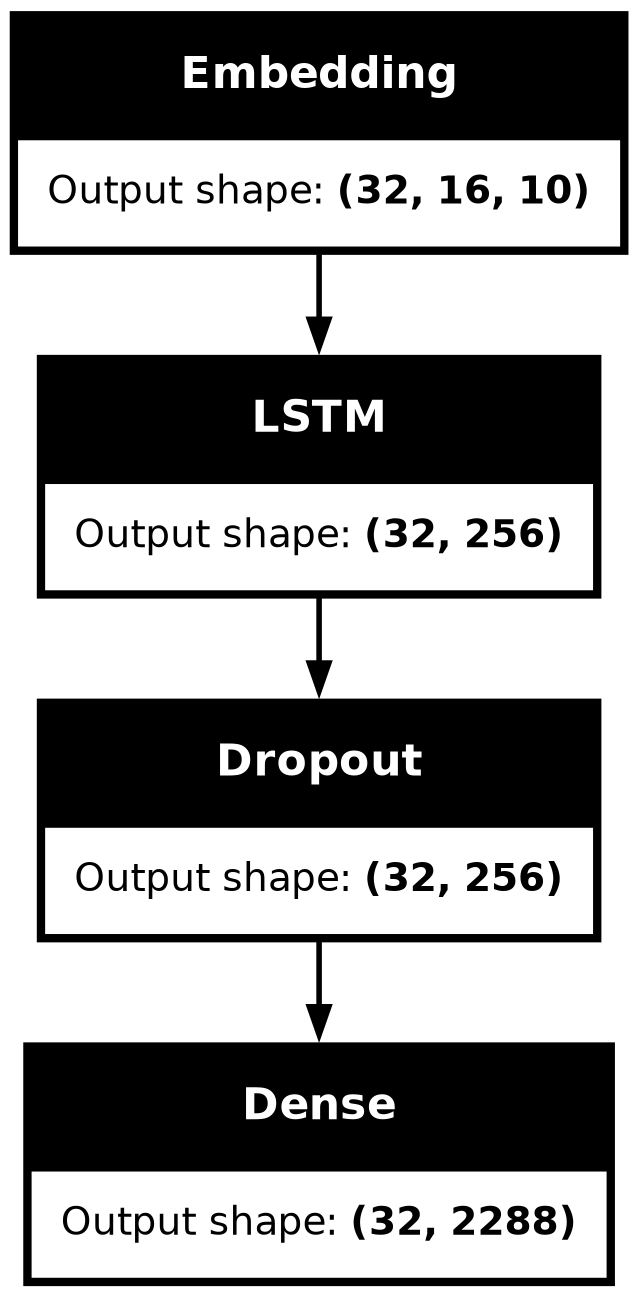

In [111]:
ku.plot_model(model, show_shapes = True)

### plot loss at 300 epochs

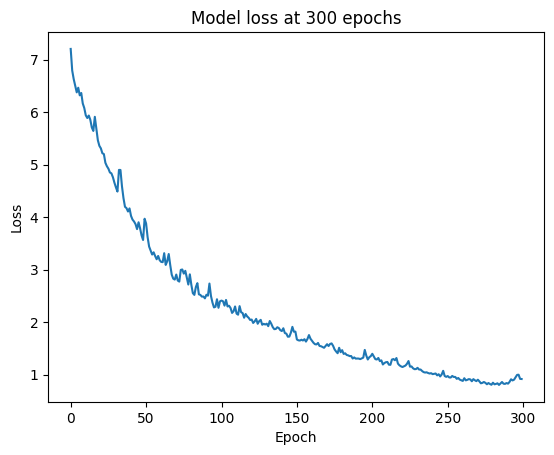

In [114]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss at 300 epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## 5.TEST MODEL

#### 5.1 Generating the text 

In [115]:
def generate_text(seed_text, num_next_words, model, max_sequence_length):
    for _ in range(num_next_words):
        
        # tokenized the input model
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
        # padd the seqeunces
        token_list = pad_sequences([token_list], maxlen = max_sequence_length, padding = 'pre')
        
        # feed the preprocessed input data into the model to generate the next word
        predict_probs = model.predict(token_list)[0]
        predict_index = np.argmax(predict_probs)
        
        # decode the sequence into human readable format
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predict_index:
                output_word = word
                break
            
        # update the seed text (input_taken + generate word --> to predict next word)
        seed_text += " " + output_word
        
    return seed_text.title()
                

## 6. Results

In [116]:
print(max_seq_len)

17


In [125]:
# test the model

print('------------- Generated Text -----------------------')
print(generate_text('who are', 10, model, max_seq_len))
print()

print('------------- Generated Text -----------------------')
print(generate_text('whats going ', 10, model, max_seq_len))
print()

print('------------- Generated Text -----------------------')
print(generate_text('President', 10, model, max_seq_len))
print()

print('------------- Generated Text -----------------------')
print(generate_text('what is news', 10, model, max_seq_len))
print()

print('------------- Generated Text -----------------------')
print(generate_text('Yesterday ', 10, model, max_seq_len))
print()



------------- Generated Text -----------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Who Are We Has Its Bills About Your Parents In The Future

------------- Generated Text -----------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Whats Going  On In This Picture Feb 6 2017 Affordable Care Act

-----------

# Streamlit App

## 1. Download the streamlit and local tunnel

In [118]:
!pip install streamlit

In [119]:
!npm install -g localtunnel

m#################.] | reify:yargs-parser: timing reifyNode:node_modules/localtK
changed 22 packages in 899ms

3 packages are looking for funding
  run `npm fund` for details


## 1.1 Create app.py file

In [120]:
%%writefile app.py

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import tensorflow.keras.utils as ku
import streamlit as st
import tensorflow as tf
import json

# Load the tokenizer from the JSON file
with open("tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer_json = json.loads(f.read())
    tokenizer = tokenizer_from_json(tokenizer_json)

# Function to generate text based on input sequence
def generate_text(seed_text, num_next_words, model, max_sequence_length):
    for num in range(num_next_words):
        
        # Tokenize the input sequence
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
        # Pad the sequence
        token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')
        
        # Feed the preprocessed input data into the model to generate the next word
        predicted_probs = model.predict(token_list)[0]
        
        # Find the index of the word with the highest probability
        predicted_index = np.argmax(predicted_probs)
        
        # Find the word corresponding to the predicted index
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
            
        # Update the seed text (input taken + generated word --> to predict next word)
        seed_text += " " + output_word
    
    return seed_text.title()

# Streamlit app
def main():
    st.title("Text Generation App")
    
    # load the model
    model = tf.keras.models.load_model('model.h5')
    
    # Input sequence from the user
    input_sequence = st.text_input("Enter the input sequence:")
    
    # Number of words to generate
    num_next_words = st.slider("Number of next words to generate:", min_value=1, max_value=10, value=5)
    
    # Specifying the max sequence length
    max_seq_len = 17
    
    # Button to generate text
    if st.button("Generate Text"):
        # Generate text based on the input sequence
        generated_text = generate_text(input_sequence, num_next_words, model, max_seq_len)
        
        # Display the generated text
        st.write("Generated Text:", generated_text)

if __name__ == "__main__":
    main()

Overwriting app.py


## 1.3 Run Streamlit app 

In [121]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [122]:
! streamlit --version

Streamlit, version 1.33.0


In [123]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.19.2.2:8501
  External URL: http://34.80.68.77:8501

your url is: https://icy-plums-tickle.loca.lt
2024-04-21 09:21:52.862332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:191] failed to create cublas handle: the resource allocation failed
2024-04-21 09:21:52.862378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:194] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2024-04-21 09:21:52.871 Uncaught app exception
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 584, in _run_script
    exec(code, module.__dict__)
  File "/kaggle/working/app.py", line 72, in <module>
    main